# Лабораторная работа "Уравнение переноса"

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math as m
from ipywidgets import interact, widgets, interactive
import warnings
warnings.filterwarnings('ignore')

class GridFunction:
    def __init__(self, a, b, h, ydim=1):
        a = np.asarray(a)
        b = np.asarray(b)
        h = np.asarray(h)
        self.ydim = ydim
        self.xdim = 1 if np.shape(a) == () else np.shape(a)[0]

        if self.xdim > 1:
            self.n = ((np.array(b) - a) / h).astype(int) + np.ones(self.xdim, dtype=int)
        else:
            self.n = int((b - a) / h) + 1

        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        if self.xdim == 1:
            self.x = np.zeros(self.n)
            for i in range(self.n):
                self.x[i] = a + self.h * i
        else:
            self.x = np.zeros(np.append(self.n, self.xdim))
            for i in np.ndindex(tuple(self.n)):
                self.x[i] = a + self.h * i

        if self.ydim == 0:
            self.y = [[0]] * self.n
        elif self.ydim == 1:
            self.y = np.zeros(self.n)
        else:
            self.y = np.zeros(np.append(self.n, self.ydim))

    def calc(self, func):
        self.f = func
        if self.xdim == 1:
            for i in range(self.n):
                self.y[i] = func(self.x[i])
        else:
            for i in np.ndindex(tuple(self.n)):
                self.y[i] = func(self.x[i])

    def plot(self, xaxis=None, marker='', label='', title_str='', figsize=(9, 6), new=True, ext_plt=None):
        if new and ext_plt is None and xaxis != '3d':
            fig, self.ax = plt.subplots(figsize=figsize)
            self.ax.set(xlabel='x', ylabel='y', title=title_str)
            self.ax.grid()

        if ext_plt is not None:
            self.ax = ext_plt

        if self.ydim == 0:
            x = []
            y = []
            for i in range(self.n):
                for j in range(len(self.y[i])):
                    x.append(self.x[i])
                    y.append(self.y[i][j])

            if label == '':
                self.ax.scatter(x, y, s=0.3)
            else:
                self.ax.scatter(x, y, s=0.3, label=label)
                self.ax.legend()
        else:
            x = self.x
            y = self.y

            if xaxis is not None:
                if xaxis == '3d':
                    x = np.split(self.x, 2, 2)[0][::, ::self.n[1]].reshape(self.n[0])
                    y = np.split(self.x, 2, 2)[1][0].reshape(self.n[1])
                    x, y = np.meshgrid(x, y)
                    x = np.transpose(x)
                    y = np.transpose(y)
                    z = self.y

                    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                    ax.plot_surface(x, y, z, linewidth=0, antialiased=False, cmap=cm.coolwarm)
                    return
                else:
                    x = np.split(self.x, 2, 2)[0][::, ::self.n[1]].reshape(self.n[0])
                    y = np.split(self.y, self.n[1], 1)[xaxis].reshape(self.n[0])

            if label == '':
                self.ax.plot(x, y, marker)
            else:
                self.ax.plot(x, y, marker, label=label)
                self.ax.legend()

def tridiagonal(a, b, c, d):
    nf = len(d)
    for it in range(1, nf):
        mc = a[it] / b[it - 1]
        b[it] = b[it] - mc * c[it - 1]
        d[it] = d[it] - mc * d[it - 1]

    x = b
    x[-1] = d[-1] / b[-1]
    for il in range(nf - 2, -1, -1):
        x[il] = (d[il] - c[il] * x[il + 1]) / b[il]

    return x

def init(gf, phi, psi):
    for n in range(gf.n[1]):
        gf.y[0, n] = psi(gf.x[0, n][1])

    for i in range(gf.n[0]):
        gf.y[i, 0] = phi(gf.x[i, 0][0])

rd_angle     = lambda u, i, n, h, t, a: u[i, n] - t * a / h * (u[i, n] - u[i - 1, n])
ru_angle     = lambda u, i, n, h, t, a: (u[i - 1, n] * a * t + h * u[i, n - 1]) / (h + a * t)
lax_wendroff = lambda u, i, n, h, t, a: u[i, n] - 0.5 * t * a / h * (u[i + 1, n] * (1.0 - t * a / h) - u[i - 1, n] * (1.0 + t * a / h) + u[i, n] * t * a / h * 2.0)

def right_ex_11(gf, phi, psi, a):
    init(gf, phi, psi)
    for n in range(1, gf.n[1]):
        for i in range(1, gf.n[0]):
            gf.y[i, n] = rd_angle(gf.y, i, n - 1, gf.h[0], gf.h[1], a)

def right_im_11(gf, phi, psi, a):
    init(gf, phi, psi)
    for n in range(1, gf.n[1]):
        for i in range(1, gf.n[0]):
            gf.y[i, n] = ru_angle(gf.y, i, n, gf.h[0], gf.h[1], a)

def lax_wendroff_ex_22(gf, phi, psi, a):
    init(gf, phi, psi)
    for n in range(1, gf.n[1]):
        for i in range(1, gf.n[0] - 1):
            gf.y[i, n] = lax_wendroff(gf.y, i, n - 1, gf.h[0], gf.h[1], a)
        i = gf.n[0] - 1
        gf.y[i, n] = rd_angle(gf.y, i, n - 1, gf.h[0], gf.h[1], a)

$$
\begin{equation*}
    \begin{cases}
    u_t + au_x = 0, \ 0<x<L, \ 0<t<T, \\
    u(x, 0) = \phi(x) \\
    u(0, t) = \psi(t) \\
    \end{cases}
\end{equation*}
$$

In [7]:
T = L = 10.0

a = 1.0
phi = lambda x: m.exp(-m.pow(x - 2.5, 2.0))
psi = lambda t: phi(-a * t)

c = 1.0
h = 0.05
tau = c * h / abs(a)

gf1 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf2 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf3 = GridFunction([0.0, 0.0], [L, T], [h, tau])

right_ex_11(gf1, phi, psi, a)
right_im_11(gf2, phi, psi, a)
lax_wendroff_ex_22(gf3, phi, psi, a)

def plot_slice(t):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set(title='Явный правый уголок')
    ax[1].set(title='Неявный правый уголок')
    ax[2].set(title='Схема Лакса-Вендроффа')
    ax[0].grid(); ax[1].grid(); ax[2].grid()
    ax[0].set_ylim([0.0, 1.5])
    ax[1].set_ylim([0.0, 1.5])
    ax[2].set_ylim([0.0, 1.5])

    gf1.plot(xaxis=int(t * gf1.n[1]), ext_plt=ax[0])
    gf2.plot(xaxis=int(t * gf2.n[1]), ext_plt=ax[1])
    gf3.plot(xaxis=int(t * gf3.n[1]), ext_plt=ax[2])

widg = interactive(plot_slice, t=widgets.FloatSlider(min=0.0,max=0.99,step=0.0001,value=0.0))
widg

interactive(children=(FloatSlider(value=0.0, description='t', max=0.99, step=0.0001), Output()), _dom_classes=…

In [3]:
T = L = 10.0

a = 1.0
phi = lambda x: 1.0 if 1.0 < x and x < 2.0 else 0.0
psi = lambda t: phi(-a * t)

c = 0.5
h = 0.05
tau = c * h / abs(a)

gf1 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf2 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf3 = GridFunction([0.0, 0.0], [L, T], [h, tau])

right_ex_11(gf1, phi, psi, a)
right_im_11(gf2, phi, psi, a)
lax_wendroff_ex_22(gf3, phi, psi, a)

def plot_slice(t):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set(title='Явный правый уголок')
    ax[1].set(title='Неявный правый уголок')
    ax[2].set(title='Схема Лакса-Вендроффа')
    ax[0].grid(); ax[1].grid(); ax[2].grid()
    ax[0].set_ylim([0.0, 1.5])
    ax[1].set_ylim([0.0, 1.5])
    ax[2].set_ylim([0.0, 1.5])

    gf1.plot(xaxis=int(t * gf1.n[1]), ext_plt=ax[0])
    gf2.plot(xaxis=int(t * gf2.n[1]), ext_plt=ax[1])
    gf3.plot(xaxis=int(t * gf3.n[1]), ext_plt=ax[2])

widg = interactive(plot_slice, t=widgets.FloatSlider(min=0.0,max=0.99,step=0.0001,value=0.0))
widg

interactive(children=(FloatSlider(value=0.0, description='t', max=0.99, step=0.0001), Output()), _dom_classes=…

In [4]:
T = L = 10.0

a = 1.0
phi = lambda x: 1.0 if x < 2.0 else 0.0
psi = lambda t: phi(-a * t)

c = 0.5
h = 0.05
tau = c * h / abs(a)

gf1 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf2 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf3 = GridFunction([0.0, 0.0], [L, T], [h, tau])

right_ex_11(gf1, phi, psi, a)
right_im_11(gf2, phi, psi, a)
lax_wendroff_ex_22(gf3, phi, psi, a)

def plot_slice(t):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set(title='Явный правый уголок')
    ax[1].set(title='Неявный правый уголок')
    ax[2].set(title='Схема Лакса-Вендроффа')
    ax[0].grid(); ax[1].grid(); ax[2].grid()
    ax[0].set_ylim([0.0, 1.5])
    ax[1].set_ylim([0.0, 1.5])
    ax[2].set_ylim([0.0, 1.5])

    gf1.plot(xaxis=int(t * gf1.n[1]), ext_plt=ax[0])
    gf2.plot(xaxis=int(t * gf2.n[1]), ext_plt=ax[1])
    gf3.plot(xaxis=int(t * gf3.n[1]), ext_plt=ax[2])

widg = interactive(plot_slice, t=widgets.FloatSlider(min=0.0,max=0.99,step=0.0001,value=0.0))
widg

interactive(children=(FloatSlider(value=0.0, description='t', max=0.99, step=0.0001), Output()), _dom_classes=…

In [5]:
T = L = 10.0

a = -1.0
phi = lambda x: 1.0 if 8.0 < x else 0.0
psi = lambda t: phi(-a * t)

c = 0.5
h = 0.05
tau = c * h / abs(a)

gf1 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf2 = GridFunction([0.0, 0.0], [L, T], [h, tau])
gf3 = GridFunction([0.0, 0.0], [L, T], [h, tau])

right_ex_11(gf1, phi, psi, a)
right_im_11(gf2, phi, psi, a)
lax_wendroff_ex_22(gf3, phi, psi, a)

def plot_slice(t):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set(title='Явный правый уголок')
    ax[1].set(title='Неявный правый уголок')
    ax[2].set(title='Схема Лакса-Вендроффа')
    ax[0].grid(); ax[1].grid(); ax[2].grid()
    ax[0].set_ylim([0.0, 1.5])
    ax[1].set_ylim([0.0, 1.5])
    ax[2].set_ylim([0.0, 1.5])

    gf1.plot(xaxis=int(t * gf1.n[1]), ext_plt=ax[0])
    gf2.plot(xaxis=int(t * gf2.n[1]), ext_plt=ax[1])
    gf3.plot(xaxis=int(t * gf3.n[1]), ext_plt=ax[2])

widg = interactive(plot_slice, t=widgets.FloatSlider(min=0.0,max=0.99,step=0.0001,value=0.0))
widg

interactive(children=(FloatSlider(value=0.0, description='t', max=0.99, step=0.0001), Output()), _dom_classes=…

In [6]:
def plot_log_err(begin_h, end_h, step_h, method):
    gf_err = GridFunction(begin_h, end_h, step_h)

    for i in range(gf_err.n):
        a = 1.0
        phi = lambda x: m.exp(-m.pow(x - 2.5, 2.0))
        psi = lambda t: phi(-a * t)

        c = 0.9
        h = gf_err.x[i]
        tau = c * h / abs(a)

        gf = GridFunction([0.0, 0.0], [L, T], [h, tau])
        method(gf, phi, psi, a)

        true_f = lambda x: phi(x[0] - a * x[1])
        true_gf = GridFunction([0.0, 0.0], [L, T], [h, tau])
        true_gf.calc(true_f)

        err = np.amax(np.abs(gf.y - true_gf.y))
        gf_err.y[i] = m.log(err)
        gf_err.x[i] = m.log(gf_err.x[i])

    fig, ax = plt.subplots(figsize=(6,6))
    ax.grid()
    gf_err.plot(ext_plt=ax)
    k, b = np.polyfit(gf_err.x, gf_err.y, 1)
    label = 'bestfit {:.2f}*x + {:.2f}'.format(k, b)
    ax.plot(gf_err.x, k * gf_err.x + b, 'r-', linewidth=0.5, label=label)
    ax.legend()

#### Явный правый уголок

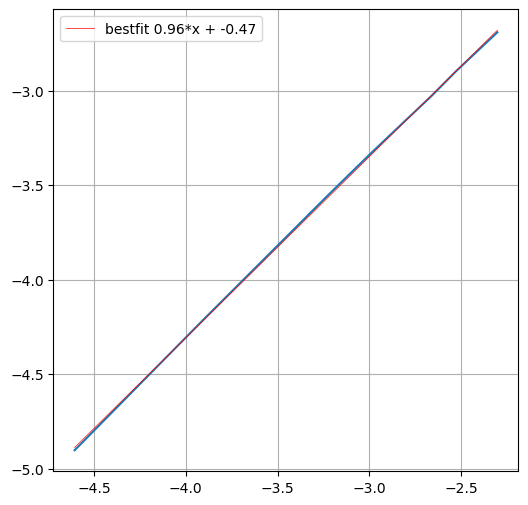

In [261]:
plot_log_err(0.01, 0.1, 0.01, right_ex_11)

#### Неявный правый уголок

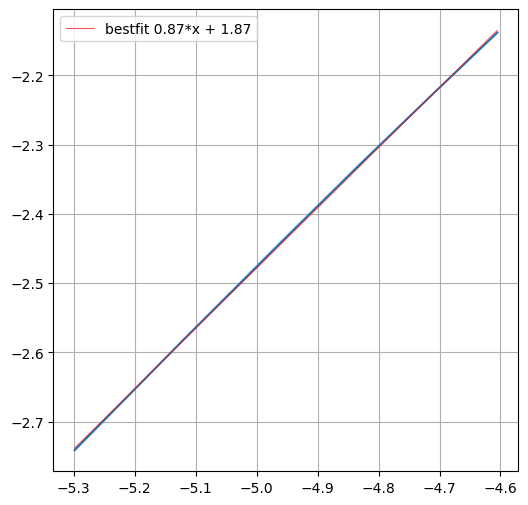

In [266]:
plot_log_err(0.005, 0.01, 0.001, right_im_11)

#### Схема Лакса-Вендроффа

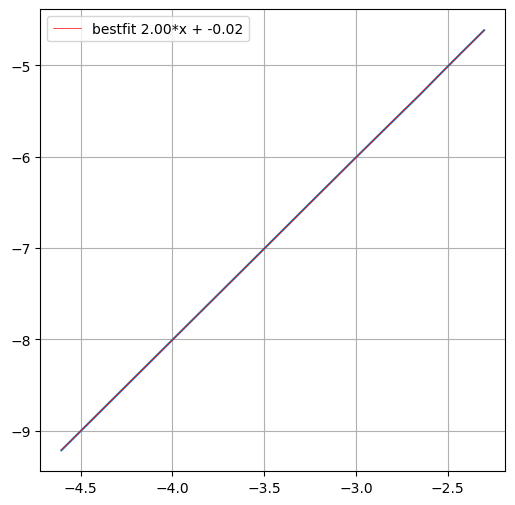

In [267]:
plot_log_err(0.01, 0.1, 0.01, lax_wendroff_ex_22)